In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from pyod.models.knn import KNN
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

In [2]:
data = pd.read_csv("../outputs/clean_houses.csv", index_col=0)

In [3]:
data.head()

,neighborhood_id,house_type_id,is_renewal_needed,is_new_development,sq_mt_built,n_rooms,n_bathrooms,floor,is_exterior,has_lift,has_parking,has_storage_room,has_terrace,has_balcony,has_pool,buy_price,buy_price_by_area,latitude,longitude
0,"San Cristóbal, Villaverde(Madrid)",HouseType 1: Pisos,False,False,64.0,2,1.0,3,True,False,False,False,False,False,False,85000,1328,40.343263,-3.688352
1,"Los Ángeles, Villaverde(Madrid)",HouseType 1: Pisos,True,False,70.0,3,1.0,4,True,True,False,False,True,False,False,129900,1856,40.355109,-3.700105
2,"San Andrés, Villaverde(Madrid)",HouseType 1: Pisos,False,False,94.0,2,2.0,1,True,True,False,True,False,False,False,144247,1535,40.345539,-3.710970
3,"San Andrés, Villaverde(Madrid)",HouseType 1: Pisos,False,False,64.0,2,1.0,Bajo,True,True,False,True,False,False,False,109900,1717,40.345539,-3.710970
4,"Los Rosales, Villaverde(Madrid)",HouseType 1: Pisos,False,False,108.0,2,2.0,4,True,True,True,True,False,False,True,260000,2407,40.355841,-3.688399


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17398 entries, 0 to 17397
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   neighborhood_id     17398 non-null  object 
 1   house_type_id       17398 non-null  object 
 2   is_renewal_needed   17398 non-null  bool   
 3   is_new_development  17398 non-null  bool   
 4   sq_mt_built         17398 non-null  float64
 5   n_rooms             17398 non-null  int64  
 6   n_bathrooms         17398 non-null  float64
 7   floor               17398 non-null  object 
 8   is_exterior         17398 non-null  bool   
 9   has_lift            17398 non-null  bool   
 10  has_parking         17398 non-null  bool   
 11  has_storage_room    17398 non-null  bool   
 12  has_terrace         17398 non-null  bool   
 13  has_balcony         17398 non-null  bool   
 14  has_pool            17398 non-null  bool   
 15  buy_price           17398 non-null  int64  
 16  buy_

# Para realizar nuestro predictor de precios de pisos, vamos a acotar los datos a los que suelen ser standard. Para ello, vamos a echar un pequeño vistazo a los datos que componen nuestro dataset.

In [5]:
data.house_type_id.value_counts()

HouseType 1: Pisos     15858
HouseType 5: Áticos      910
HouseType 4: Dúplex      630
Name: house_type_id, dtype: int64

### La gran mayoría de los datos se corresponden con la tipología pisos, por lo que vamos a eliminar el resto de tipologías

In [6]:
data = data.drop(data[data["house_type_id"]=="HouseType 4: Dúplex"].index)
data = data.drop(data[data["house_type_id"]=="HouseType 5: Áticos"].index)

### Transformamos ahora la columna pisos a datos numéricos.

In [7]:
planta={"Bajo": 0,
       "Entreplanta exterior": -1,
        "Entreplanta interior": -1,
       "Semi-sótano exterior": -2,    
        "Semi-sótano interior": -2,   
        "Sótano interior": -3,          
        "Sótano exterior": -3}

In [8]:
data.floor = data.floor.apply(lambda x: planta.get(x, x))

In [9]:
data.floor = pd.to_numeric(data.floor)

In [10]:
# Vamos a realizar ahora un análisis estadístico de los datos numéricos.

data.describe()

,sq_mt_built,n_rooms,n_bathrooms,floor,buy_price,buy_price_by_area,latitude,longitude
count,15858.000000,15858.000000,15858.000000,15858.000000,1.585800e+04,15858.000000,15858.000000,15858.000000
mean,120.263085,2.868773,1.828415,2.498928,5.403210e+05,4046.152541,40.423061,-3.688877
std,81.550413,1.214570,1.001548,2.035698,5.901108e+05,1903.335924,0.035340,0.036562
min,16.000000,0.000000,1.000000,-3.000000,3.600000e+04,447.000000,40.339934,-3.828783
25%,70.000000,2.000000,1.000000,1.000000,1.900000e+05,2565.000000,40.397292,-3.708916
50%,95.000000,3.000000,2.000000,2.000000,3.480000e+05,3800.500000,40.424816,-3.693014
75%,140.000000,3.000000,2.000000,4.000000,6.366000e+05,5051.000000,40.445414,-3.667970
max,894.000000,15.000000,14.000000,9.000000,8.500000e+06,18889.000000,40.520554,-3.546616


### Del anterior análisis, vamos a quedarnos con los datos que tenemos entre el percentil 25% y el percentil 75% que es donde se concentran la gran mayoría de los datos.

In [11]:
data = data.drop(data[data["buy_price"]>1000000].index)
data = data.drop(data[data["sq_mt_built"]<50].index)
data = data.drop(data[data["sq_mt_built"]>200].index)#140
#data = data.drop(data[data["n_rooms"]<1].index)
data = data.drop(data[data["n_rooms"]>3].index)
data = data.drop(data[data["n_bathrooms"]<1].index)
data = data.drop(data[data["n_bathrooms"]>3].index)#2
data = data.drop(data[data["floor"]<0].index)
data = data.drop(data[data["floor"]>8].index)

In [12]:
data.describe()

,sq_mt_built,n_rooms,n_bathrooms,floor,buy_price,buy_price_by_area,latitude,longitude
count,10219.000000,10219.000000,10219.000000,10219.000000,10219.000000,10219.000000,10219.000000,10219.000000
mean,88.933066,2.406400,1.456111,2.451805,329503.330952,3610.488795,40.418242,-3.687556
std,28.518005,0.678445,0.541402,1.845336,198020.857700,1619.817965,0.037808,0.040113
min,50.000000,0.000000,1.000000,0.000000,36000.000000,447.000000,40.339934,-3.828783
25%,67.000000,2.000000,1.000000,1.000000,170000.000000,2292.000000,40.388788,-3.710970
50%,82.000000,3.000000,1.000000,2.000000,272000.000000,3298.000000,40.415129,-3.694300
75%,106.000000,3.000000,2.000000,4.000000,449000.000000,4615.000000,40.445414,-3.664238
max,200.000000,3.000000,3.000000,8.000000,1000000.000000,12923.000000,40.520554,-3.546616


In [13]:
def transf(column):

    le = preprocessing.LabelEncoder()
    data[column] = le.fit_transform(data[column])
    return data[column]

In [14]:
transf("house_type_id")
transf("is_renewal_needed")
transf("is_new_development")
transf("is_exterior")
transf("has_lift")
transf("has_parking")
transf("has_storage_room")
transf("has_terrace")
transf("has_balcony")
transf("has_pool");

In [15]:
data.head()

,neighborhood_id,house_type_id,is_renewal_needed,is_new_development,sq_mt_built,n_rooms,n_bathrooms,floor,is_exterior,has_lift,has_parking,has_storage_room,has_terrace,has_balcony,has_pool,buy_price,buy_price_by_area,latitude,longitude
0,"San Cristóbal, Villaverde(Madrid)",0,0,0,64.0,2,1.0,3,1,0,0,0,0,0,0,85000,1328,40.343263,-3.688352
1,"Los Ángeles, Villaverde(Madrid)",0,1,0,70.0,3,1.0,4,1,1,0,0,1,0,0,129900,1856,40.355109,-3.700105
2,"San Andrés, Villaverde(Madrid)",0,0,0,94.0,2,2.0,1,1,1,0,1,0,0,0,144247,1535,40.345539,-3.710970
3,"San Andrés, Villaverde(Madrid)",0,0,0,64.0,2,1.0,0,1,1,0,1,0,0,0,109900,1717,40.345539,-3.710970
4,"Los Rosales, Villaverde(Madrid)",0,0,0,108.0,2,2.0,4,1,1,1,1,0,0,1,260000,2407,40.355841,-3.688399


In [16]:
data.loc[data["neighborhood_id"]=="Malasaña-Universidad, Centro(Madrid)"]

,neighborhood_id,house_type_id,is_renewal_needed,is_new_development,sq_mt_built,n_rooms,n_bathrooms,floor,is_exterior,has_lift,has_parking,has_storage_room,has_terrace,has_balcony,has_pool,buy_price,buy_price_by_area,latitude,longitude
13588,"Malasaña-Universidad, Centro(Madrid)",0,0,0,106.0,2,2.0,2,1,1,0,0,0,0,0,565000,5330,40.426708,-3.704231
13590,"Malasaña-Universidad, Centro(Madrid)",0,0,0,79.0,2,2.0,0,1,1,0,0,0,0,0,450000,5696,40.426708,-3.704231
13611,"Malasaña-Universidad, Centro(Madrid)",0,0,0,142.0,2,1.0,1,1,1,0,0,0,1,0,550000,3873,40.426708,-3.704231
13621,"Malasaña-Universidad, Centro(Madrid)",0,0,0,153.0,3,2.0,4,1,1,0,0,0,1,0,775000,5065,40.426708,-3.704231
13632,"Malasaña-Universidad, Centro(Madrid)",0,0,0,78.0,1,1.0,3,1,0,0,0,0,0,0,485000,6218,40.426708,-3.704231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17308,"Malasaña-Universidad, Centro(Madrid)",0,0,0,119.0,3,1.0,1,1,1,0,1,0,1,0,525000,4412,40.426708,-3.704231
17310,"Malasaña-Universidad, Centro(Madrid)",0,0,0,110.0,3,2.0,1,1,0,0,0,0,1,0,550000,5000,40.426708,-3.704231
17311,"Malasaña-Universidad, Centro(Madrid)",0,0,0,55.0,1,1.0,1,1,0,0,0,0,1,0,350000,6364,40.426708,-3.704231
17321,"Malasaña-Universidad, Centro(Madrid)",0,0,0,117.0,3,2.0,1,1,1,0,1,0,1,0,555000,4744,40.426708,-3.704231


In [17]:
data.columns

Index(['neighborhood_id', 'house_type_id', 'is_renewal_needed',
       'is_new_development', 'sq_mt_built', 'n_rooms', 'n_bathrooms', 'floor',
       'is_exterior', 'has_lift', 'has_parking', 'has_storage_room',
       'has_terrace', 'has_balcony', 'has_pool', 'buy_price',
       'buy_price_by_area', 'latitude', 'longitude'],
      dtype='object')

In [18]:
data = data[['is_renewal_needed',
       'is_new_development', 'sq_mt_built', 'n_rooms', 'n_bathrooms', 'floor',
       'is_exterior', 'has_lift', 'has_parking', 'has_storage_room',
       'has_terrace', 'has_balcony', 'has_pool',
       'latitude', 'longitude', 'buy_price']]

In [19]:
clf = KNN(contamination=0.5, method="largest", algorithm="auto")
clf.fit(data)
y_pred = clf.predict(data)
dropea = data[y_pred == 1]
data = data.drop(dropea.index)

In [20]:
clf = KNN(contamination=0.5, method="largest", algorithm="auto")
clf.fit(data)
y_pred = clf.predict(data)
dropea = data[y_pred == 1]
data = data.drop(dropea.index)

In [21]:
data.describe()

,is_renewal_needed,is_new_development,sq_mt_built,n_rooms,n_bathrooms,floor,is_exterior,has_lift,has_parking,has_storage_room,has_terrace,has_balcony,has_pool,latitude,longitude,buy_price
count,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000
mean,0.179628,0.017251,77.569551,2.349945,1.286966,2.054491,0.905257,0.606517,0.179354,0.217415,0.353779,0.153067,0.115827,40.416801,-3.692043,266369.470153
std,0.383930,0.130222,19.390573,0.671600,0.461400,1.402365,0.292899,0.488589,0.383701,0.412544,0.478207,0.360101,0.320061,0.036007,0.039018,145521.342036
min,0.000000,0.000000,50.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.339934,-3.828783,90000.000000
25%,0.000000,0.000000,63.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.388788,-3.715748,154000.000000
50%,0.000000,0.000000,74.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.410719,-3.699327,220000.000000
75%,0.000000,0.000000,87.000000,3.000000,2.000000,3.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,40.443621,-3.661223,350000.000000
max,1.000000,1.000000,160.000000,3.000000,3.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,40.520554,-3.546616,850000.000000


In [22]:
data.to_csv("..\outputs\h2o.csv")

In [23]:
"""sns.pairplot(data, size=2.5, vars=data)
plt.tight_layout()"""

'sns.pairplot(data, size=2.5, vars=data)\nplt.tight_layout()'

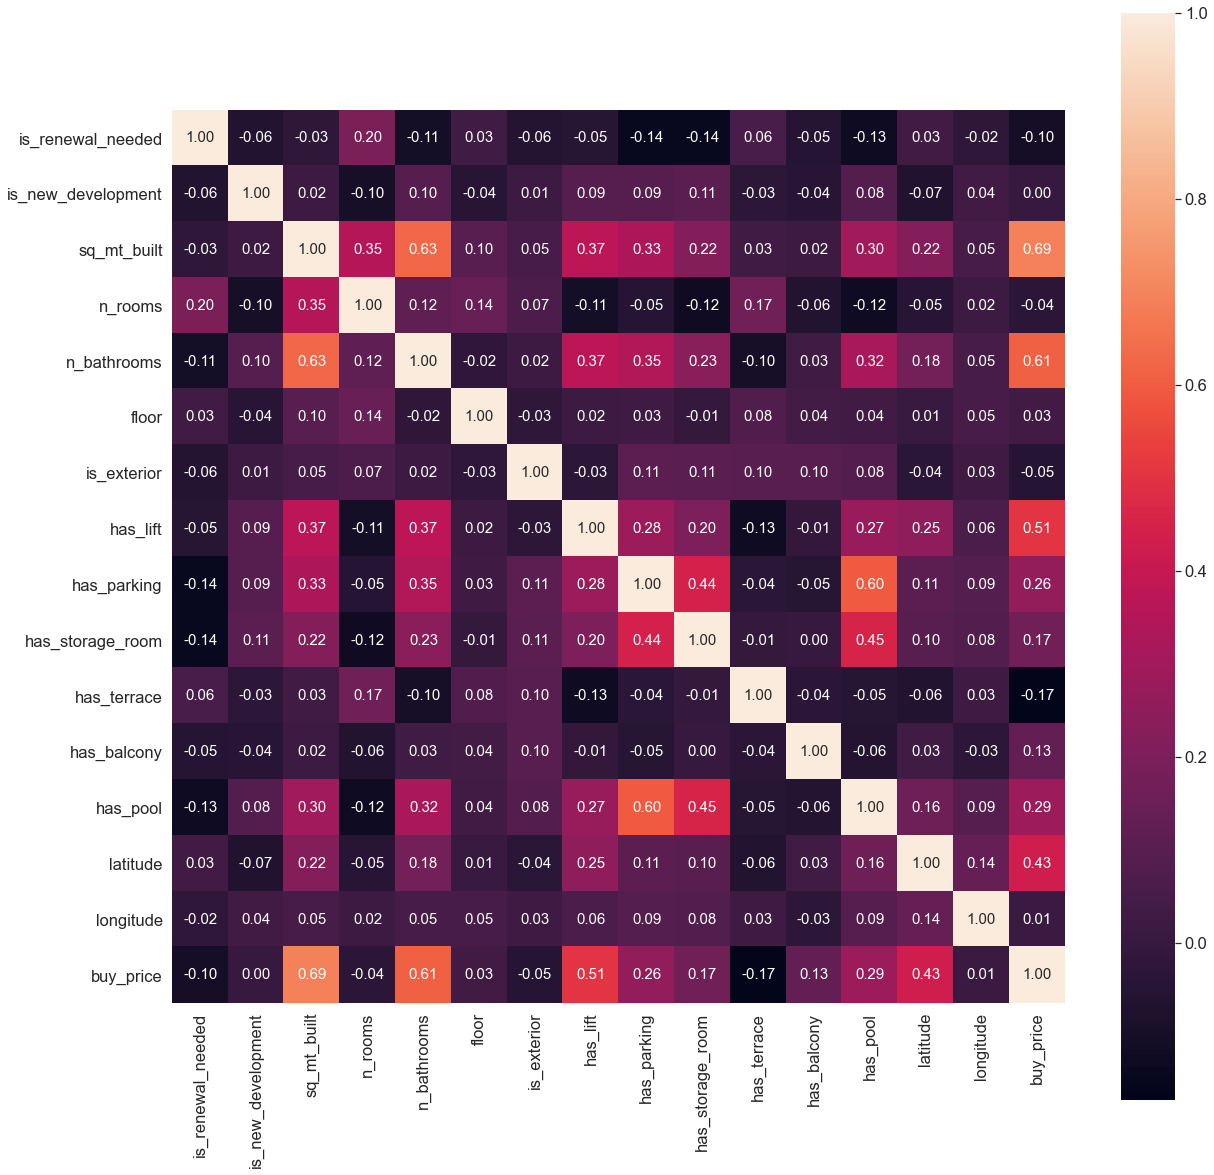

In [24]:
# Heatmap.

cm = np.corrcoef(data.values.T)
sns.set(font_scale=1.5)
plt.figure(figsize=(20, 20))
hm = sns.heatmap(cm,
                 cbar=True,
                annot=True,
                square=True,
                fmt='.2f',
                annot_kws={'size': 15},
                yticklabels=data.columns,
                xticklabels=data.columns)

In [25]:
features = data.drop(["buy_price"], axis=1)
X = features
y = data['buy_price']

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=7)

In [27]:
models = {
    "XGBRegressor" : XGBRegressor(),
    "DecisionTree" : DecisionTreeRegressor(),
    "RandomForest": RandomForestRegressor(),
    "ExtraTrees" : ExtraTreesRegressor(),
    "GradientBoosting" : GradientBoostingRegressor(),
    "HistGradientBoosting": HistGradientBoostingRegressor(),
    "Voting": VotingRegressor(
        [('etr', ExtraTreesRegressor()),
         ('rf', RandomForestRegressor())]
    )
}

In [28]:
for name, model in models.items():
    print(f"Entrenando {name}")
    model.fit(X_train, y_train)
print("Proceso terminado")

Entrenando XGBRegressor
Entrenando DecisionTree
Entrenando RandomForest
Entrenando ExtraTrees
Entrenando GradientBoosting
Entrenando HistGradientBoosting
Entrenando Voting
Proceso terminado


-------XGBRegressor-------
RMSE 39896.269
R2 0.917
-------DecisionTree-------
RMSE 53783.902
R2 0.85
-------RandomForest-------
RMSE 39434.792
R2 0.919
-------ExtraTrees-------
RMSE 42308.135
R2 0.907
-------GradientBoosting-------
RMSE 43338.196
R2 0.902
-------HistGradientBoosting-------
RMSE 38679.853
R2 0.922
-------Voting-------
RMSE 39254.784
R2 0.92


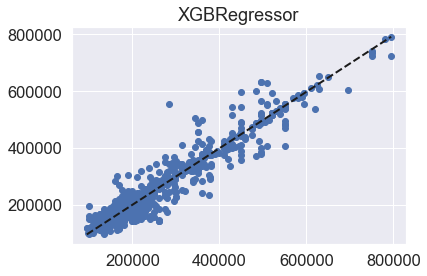

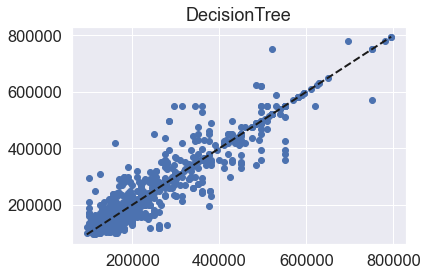

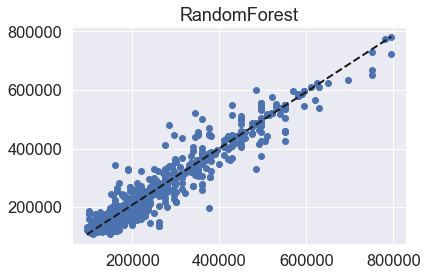

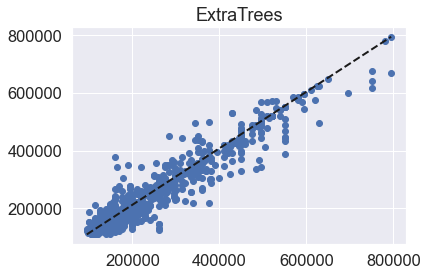

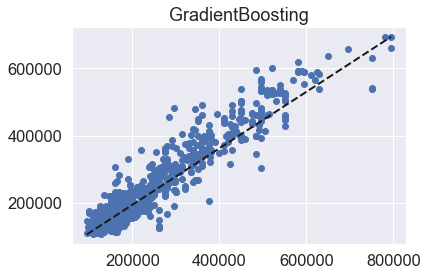

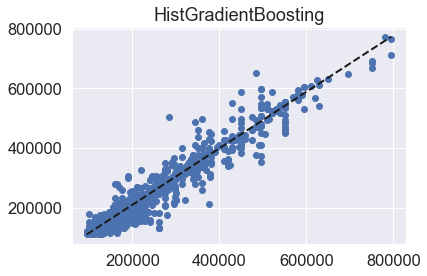

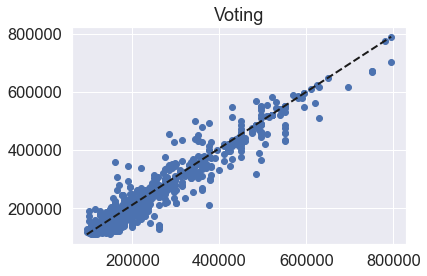

In [29]:
for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"-------{name}-------")
    print("RMSE", round(np.sqrt(mean_squared_error(y_test,y_pred)),3))
    print("R2", round(r2_score(y_test,y_pred),3))
    plt.figure()
    plt.title(name)
    plt.scatter(y_test,y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_pred.min(), y_pred.max()], 'k--', lw=2)

## Test con H2O

In [62]:
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators import H2OXGBoostEstimator

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,44 mins 34 secs
H2O_cluster_timezone:,Europe/Madrid
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,15 days
H2O_cluster_name:,H2O_from_python_Javi_geldd1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.457 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [32]:
h2train = h2o.H2OFrame(data)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [37]:
features = data.drop(["buy_price"], axis=1)

x = list(features)
y = "buy_price"

In [38]:
from h2o.automl import H2OAutoML

automl = H2OAutoML(max_runtime_secs=1200, sort_metric='RMSE')
automl.train(x, y, training_frame=h2train)
leader_board = automl.leaderboard
leader_board.head()

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,rmse,mean_residual_deviance,mse,mae,rmsle
StackedEnsemble_BestOfFamily_AutoML_20201014_105559,36060.1,1.30033e+09,1.30033e+09,23854,0.141285
GBM_grid__1_AutoML_20201014_105559_model_3,37359.7,1.39575e+09,1.39575e+09,25116.7,0.147176
GBM_4_AutoML_20201014_105559,37498.1,1.40611e+09,1.40611e+09,25311.6,0.146872
GBM_grid__1_AutoML_20201014_105559_model_96,37537.7,1.40908e+09,1.40908e+09,25607.2,0.147775
GBM_grid__1_AutoML_20201014_105559_model_4,37540.9,1.40932e+09,1.40932e+09,24344.8,0.147571
GBM_grid__1_AutoML_20201014_105559_model_25,37639,1.4167e+09,1.4167e+09,24909.5,0.146569
XGBoost_grid__1_AutoML_20201014_105559_model_18,37654.4,1.41785e+09,1.41785e+09,25032.9,0.145993
GBM_grid__1_AutoML_20201014_105559_model_56,37768.4,1.42646e+09,1.42646e+09,25587.4,0.147471
GBM_grid__1_AutoML_20201014_105559_model_83,37821.1,1.43044e+09,1.43044e+09,25529.4,0.146824
GBM_grid__1_AutoML_20201014_105559_model_28,38004.4,1.44433e+09,1.44433e+09,25677.4,0.149079


## H2O Random Forest

In [181]:
data = h2o.import_file("..\outputs\h2o.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [182]:
X = data.col_names[1:-1]
y = data.col_names[-1]

train, test =data.split_frame([0.8], seed=1234)

In [183]:
rf_h2o = H2ORandomForestEstimator()
houses_model = rf_h2o.train(X, y, training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [184]:
print(rf_h2o)

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1602665690260_10


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,2231321.0,20.0,20.0,20.0,3356.0,3671.0,3546.24




ModelMetricsRegression: drf
** Reported on train data. **

MSE: 5539623672.141282
RMSE: 74428.6481950417
MAE: 41394.72002027501
RMSLE: 0.15931527287728078
Mean Residual Deviance: 5539623672.141282

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2020-10-14 14:06:19,0.003 sec,0.0,NaN,NaN,NaN
1,,2020-10-14 14:06:19,0.150 sec,1.0,118846.137394,57044.325323,1.412440e+10
2,,2020-10-14 14:06:19,0.253 sec,2.0,146411.606628,61854.330219,2.143636e+10
3,,2020-10-14 14:06:19,0.319 sec,3.0,135999.255032,59138.603860,1.849580e+10
4,,2020-10-14 14:06:19,0.362 sec,4.0,126332.590637,57115.801976,1.595992e+10
5,,2020-10-14 14:06:19,0.440 sec,5.0,116757.819219,55636.285427,1.363239e+10
6,,2020-10-14 14:06:19,0.490 sec,6.0,117298.848033,54962.434788,1.375902e+10
7,,2020-10-14 14:06:19,0.555 sec,7.0,108187.909320,53555.699403,1.170462e+10
8,,2020-10-14 14:06:19,0.664 sec,8.0,105333.940083,52726.120383,1.109524e+10
9,,2020-10-14 14:06:20,0.779 sec,9.0,102905.887353,51423.557568,1.058962e+10



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,sq_mt_built,2.294095e+16,1.000000,0.519050
1,n_bathrooms,8.364762e+15,0.364621,0.189257
2,n_rooms,4.509852e+15,0.196585,0.102038
3,latitude,3.842345e+15,0.167489,0.086935
4,longitude,1.534752e+15,0.066900,0.034725
5,has_lift,1.209486e+15,0.052722,0.027365
6,floor,6.505490e+14,0.028358,0.014719
7,has_parking,2.849856e+14,0.012423,0.006448
8,has_storage_room,2.085099e+14,0.009089,0.004718
9,has_terrace,1.652255e+14,0.007202,0.003738


In [185]:
predict = rf_h2o.predict(test)

drf prediction progress: |████████████████████████████████████████████████| 100%


In [186]:
test, predict

C1,is_renewal_needed,is_new_development,sq_mt_built,n_rooms,n_bathrooms,floor,is_exterior,has_lift,has_parking,has_storage_room,has_terrace,has_balcony,has_pool,latitude,longitude,buy_price
4,0,0,108,2,2,4,1,1,1,1,0,0,1,40.3558,-3.6884,260000
15,1,0,75,3,1,3,1,1,0,0,1,0,0,40.3455,-3.71097,129900
25,0,0,72,2,1,3,1,0,1,0,0,1,0,40.3455,-3.71097,138000
35,0,0,74,3,1,1,1,0,0,1,0,0,0,40.3551,-3.7001,139000
37,0,0,126,4,2,0,1,1,1,1,1,0,1,40.3399,-3.67339,275000
39,0,0,108,3,2,4,1,1,0,0,1,0,0,40.3551,-3.7001,179000
40,0,0,62,2,1,0,1,1,0,0,0,0,0,40.3455,-3.71097,123000
46,0,1,105,3,2,1,1,1,1,1,1,0,1,40.3399,-3.67339,204999
82,0,0,52,2,1,1,1,0,0,0,0,0,0,40.3558,-3.6884,100000
91,0,0,70,2,2,4,1,1,1,1,0,0,1,40.3558,-3.6884,210000


predict
263870
136326
140078
133403
275800
227550
119013
265300
101714
226471


(, )

In [187]:
print("RMSE", round(rf_h2o.model_performance(test).rmse(),3))
print("R2", round(rf_h2o.model_performance(test).r2(),3))

RMSE 70512.306
R2 0.971


## GradientBoosting

In [188]:
gbm_h2o = H2OGradientBoostingEstimator()
houses_model = gbm_h2o.train(X, y, training_frame=train)
print(gbm_h2o)

gbm Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1602665690260_11


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,20418.0,5.0,5.0,5.0,18.0,32.0,27.78




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 4559858901.073359
RMSE: 67526.72730906896
MAE: 43972.93507727415
RMSLE: 0.16786952167302568
Mean Residual Deviance: 4559858901.073359

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2020-10-14 14:07:18,0.012 sec,0.0,402898.569846,247172.654059,1.623273e+11
1,,2020-10-14 14:07:18,0.071 sec,1.0,366276.578416,225316.669689,1.341585e+11
2,,2020-10-14 14:07:18,0.097 sec,2.0,333515.401116,205989.584692,1.112325e+11
3,,2020-10-14 14:07:18,0.114 sec,3.0,304412.794991,188616.870606,9.266715e+10
4,,2020-10-14 14:07:18,0.131 sec,4.0,278253.907096,173268.898518,7.742524e+10
5,,2020-10-14 14:07:18,0.153 sec,5.0,254934.425372,159598.509429,6.499156e+10
6,,2020-10-14 14:07:18,0.170 sec,6.0,234284.261118,147508.897859,5.488912e+10
7,,2020-10-14 14:07:18,0.187 sec,7.0,215834.489308,136723.753543,4.658453e+10
8,,2020-10-14 14:07:18,0.204 sec,8.0,199510.083322,126940.892109,3.980427e+10
9,,2020-10-14 14:07:18,0.232 sec,9.0,185236.784121,118550.560185,3.431267e+10



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,sq_mt_built,5.078895e+15,1.000000,0.854026
1,latitude,4.163359e+14,0.081974,0.070008
2,longitude,1.554065e+14,0.030598,0.026132
3,n_bathrooms,1.423189e+14,0.028022,0.023931
4,n_rooms,5.569196e+13,0.010965,0.009365
5,has_lift,4.214997e+13,0.008299,0.007088
6,floor,2.606052e+13,0.005131,0.004382
7,has_pool,1.165024e+13,0.002294,0.001959
8,has_terrace,7.673121e+12,0.001511,0.001290
9,is_renewal_needed,4.782916e+12,0.000942,0.000804


In [189]:
print("RMSE", round(gbm_h2o.rmse(),3))
print("R2", round(gbm_h2o.r2(),3))

RMSE 67526.727
R2 0.972


In [190]:
predict = gbm_h2o.predict(test)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [191]:
test, predict

C1,is_renewal_needed,is_new_development,sq_mt_built,n_rooms,n_bathrooms,floor,is_exterior,has_lift,has_parking,has_storage_room,has_terrace,has_balcony,has_pool,latitude,longitude,buy_price
4,0,0,108,2,2,4,1,1,1,1,0,0,1,40.3558,-3.6884,260000
15,1,0,75,3,1,3,1,1,0,0,1,0,0,40.3455,-3.71097,129900
25,0,0,72,2,1,3,1,0,1,0,0,1,0,40.3455,-3.71097,138000
35,0,0,74,3,1,1,1,0,0,1,0,0,0,40.3551,-3.7001,139000
37,0,0,126,4,2,0,1,1,1,1,1,0,1,40.3399,-3.67339,275000
39,0,0,108,3,2,4,1,1,0,0,1,0,0,40.3551,-3.7001,179000
40,0,0,62,2,1,0,1,1,0,0,0,0,0,40.3455,-3.71097,123000
46,0,1,105,3,2,1,1,1,1,1,1,0,1,40.3399,-3.67339,204999
82,0,0,52,2,1,1,1,0,0,0,0,0,0,40.3558,-3.6884,100000
91,0,0,70,2,2,4,1,1,1,1,0,0,1,40.3558,-3.6884,210000


predict
276193
150989
147313
131097
299274
216205
128990
273554
105458
217908


(, )

## H2OXGBoostEstimator

In [195]:
xgbm_h2o = H2OXGBoostEstimator()
houses_model = xgbm_h2o.train(X, y, training_frame=train)
print(xgbm_h2o)

xgboost Model Build progress: |███████████████████████████████████████████| 100%
Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_model_python_1602665690260_13


Model Summary: 


,,number_of_trees
0,,50.0




ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 1704495129.4275467
RMSE: 41285.53172029575
MAE: 28493.244412786233
RMSLE: 0.12487654120747135
Mean Residual Deviance: 1704495129.4275467

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2020-10-14 14:08:02,0.003 sec,0.0,572683.123150,406987.348646,3.279660e+11
1,,2020-10-14 14:08:02,0.042 sec,1.0,412160.576420,286121.662305,1.698763e+11
2,,2020-10-14 14:08:02,0.058 sec,2.0,300018.032878,201519.008723,9.001082e+10
3,,2020-10-14 14:08:02,0.075 sec,3.0,221590.410895,143283.858932,4.910231e+10
4,,2020-10-14 14:08:02,0.094 sec,4.0,168240.319773,105376.017125,2.830481e+10
5,,2020-10-14 14:08:02,0.110 sec,5.0,131801.327722,81598.229463,1.737159e+10
6,,2020-10-14 14:08:02,0.128 sec,6.0,107159.982567,66586.699616,1.148326e+10
7,,2020-10-14 14:08:02,0.147 sec,7.0,91232.127684,57578.868907,8.323301e+09
8,,2020-10-14 14:08:02,0.166 sec,8.0,81008.650895,52039.040221,6.562402e+09
9,,2020-10-14 14:08:02,0.185 sec,9.0,73605.512448,48108.250505,5.417771e+09



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,sq_mt_built,1.925248e+15,1.000000,0.869773
1,latitude,1.299881e+14,0.067518,0.058725
2,longitude,5.246858e+13,0.027253,0.023704
3,n_bathrooms,4.078568e+13,0.021185,0.018426
4,n_rooms,2.204903e+13,0.011453,0.009961
5,has_lift,1.653037e+13,0.008586,0.007468
6,floor,1.267546e+13,0.006584,0.005726
7,has_pool,3.525038e+12,0.001831,0.001593
8,has_terrace,2.659225e+12,0.001381,0.001201
9,is_renewal_needed,2.447439e+12,0.001271,0.001106


In [196]:
print("RMSE", round(xgbm_h2o.rmse(),3))
print("R2", round(xgbm_h2o.r2(),3))

RMSE 41285.532
R2 0.989


In [197]:
print("RMSE: ", xgbm_h2o.model_performance(test).rmse())
print("R2: ", xgbm_h2o.model_performance(test).r2())

RMSE:  65207.66631933076
R2:  0.9749100092103393


In [198]:
predict = xgbm_h2o.predict(test)

xgboost prediction progress: |████████████████████████████████████████████| 100%


In [199]:
test, predict

C1,is_renewal_needed,is_new_development,sq_mt_built,n_rooms,n_bathrooms,floor,is_exterior,has_lift,has_parking,has_storage_room,has_terrace,has_balcony,has_pool,latitude,longitude,buy_price
4,0,0,108,2,2,4,1,1,1,1,0,0,1,40.3558,-3.6884,260000
15,1,0,75,3,1,3,1,1,0,0,1,0,0,40.3455,-3.71097,129900
25,0,0,72,2,1,3,1,0,1,0,0,1,0,40.3455,-3.71097,138000
35,0,0,74,3,1,1,1,0,0,1,0,0,0,40.3551,-3.7001,139000
37,0,0,126,4,2,0,1,1,1,1,1,0,1,40.3399,-3.67339,275000
39,0,0,108,3,2,4,1,1,0,0,1,0,0,40.3551,-3.7001,179000
40,0,0,62,2,1,0,1,1,0,0,0,0,0,40.3455,-3.71097,123000
46,0,1,105,3,2,1,1,1,1,1,1,0,1,40.3399,-3.67339,204999
82,0,0,52,2,1,1,1,0,0,0,0,0,0,40.3558,-3.6884,100000
91,0,0,70,2,2,4,1,1,1,1,0,0,1,40.3558,-3.6884,210000


predict
271579
115249
144033
120578
255435
208549
105188
240311
102865
188954


(, )

# Tasación.

In [200]:
vivienda = {'neighborhood_id': "Malasaña-Universidad, Centro(Madrid)", # Uno del desplegable.
            'is_renewal_needed': True,     # True or False.
            'is_new_development': False,    # True or False.
            'sq_mt_built': 91,              # Valores inferiores a 140m2.
            'n_rooms': 3,                   # Valores inferiores a 3.
            'n_bathrooms': 2,               # Valores inferiores a 2.
            'floor': 1,                     # Del bajo a la 9ª planta.
            'is_exterior': True,            # True or False.
            'has_lift': True,               # True or False.
            'has_parking': True,            # True or False.
            'has_storage_room': True,       # True or False.
            'has_terrace': True,            # True or False.
            'has_balcony': True,            # True or False.
            'has_pool': True              # True or False.        
           }

In [201]:
geolocator = Nominatim(user_agent="http")

locate = geolocator.geocode(vivienda["neighborhood_id"], timeout=7)
vivienda["latitude"] = locate.latitude
vivienda["longitude"] = locate.longitude

In [202]:
vivienda.pop("neighborhood_id")
vivienda

{'is_renewal_needed': True,
 'is_new_development': False,
 'sq_mt_built': 91,
 'n_rooms': 3,
 'n_bathrooms': 2,
 'floor': 1,
 'is_exterior': True,
 'has_lift': True,
 'has_parking': True,
 'has_storage_room': True,
 'has_terrace': True,
 'has_balcony': True,
 'has_pool': True,
 'latitude': 40.4267079,
 'longitude': -3.7042311}

In [203]:
piso = pd.DataFrame.from_dict(vivienda, orient='index').T
piso

,is_renewal_needed,is_new_development,sq_mt_built,n_rooms,n_bathrooms,floor,is_exterior,has_lift,has_parking,has_storage_room,has_terrace,has_balcony,has_pool,latitude,longitude
0,True,False,91,3,2,1,True,True,True,True,True,True,True,40.4267,-3.70423


In [204]:
def transf(column):

    le = preprocessing.LabelEncoder()
    piso[column] = le.fit_transform(piso[column])
    return piso[column]

In [205]:
transf("is_renewal_needed")
transf("is_new_development")
transf("is_exterior")
transf("has_lift")
transf("has_parking")
transf("has_storage_room")
transf("has_terrace")
transf("has_balcony")
transf("has_pool");

In [206]:
piso.to_csv("..\outputs\new_piso.csv")

In [207]:
piso = h2o.import_file("..\outputs\new_piso.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [208]:
estimated_price = xgbm_h2o.predict(piso)
print(estimated_price)

xgboost prediction progress: |████████████████████████████████████████████| 100%


predict
426554


In [ ]:
compara = pd.DataFrame({"y_test": y_test, "y_pred": y_pred, "difference": abs(y_test - y_pred)})

In [ ]:
data = pd.concat([data, compara.reindex(compara.index)], axis=1)
data = data.dropna(how='any')

In [ ]:
data.sort_values(by="difference", ascending=False)

In [ ]:
good = data[data.difference<50000]

In [ ]:
good